In [3]:
import numpy as np

import torch

import torch.nn as nn

import torch.nn.functional as F

import matplotlib.pyplot as plt

import cv2

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from torch.nn import CrossEntropyLoss

from torch.optim import Adam

from torch.utils.data import DataLoader, TensorDataset, random_split

from torchvision.datasets.mnist import MNIST

from torchvision.transforms import ToTensor

from tqdm import tqdm

from torchvision import transforms

from torchvision.datasets import Imagenette

from torch.utils.data.sampler import SubsetRandomSampler

from mpl_toolkits.axes_grid1 import ImageGrid

from torchvision.transforms import v2

import torchvision

import math

import os

import pickle



BATCH_SIZE = 128

CLASS_NUM = 10

In [2]:
!rm -rf /kaggle/working/encoder_student.pt
!rm -rf /kaggle/working/Pickles/*
!rm -rf /kaggle/working/classifier.pt

# Data

In [4]:
class CustomTensorDataset(Dataset):

    def __init__(self, X, y, transform):

        self.X = X

        self.y = y

        self.transform = transform







    def __len__(self):

        return len(self.X)







    def __getitem__(self, idx):

        image, label = self.X[idx], self.y[idx]

        image = self.transform(image)

        return image, label

In [5]:
train_transform = transforms.Compose([

    v2.RandAugment(5,14),

    v2.RandomCrop(224, padding=16),

    v2.RandomHorizontalFlip(p=0.5),

    v2.RandomRotation(degrees=10),

    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    
    v2.ToDtype(torch.float32, scale=True),

    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

])



test_transform = transforms.Compose([

    v2.ToDtype(torch.float32, scale=True),

    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

])







train_dataset  = Imagenette('./data/',split='train',transform=transforms.Compose([v2.Resize((224, 224)), v2.ToImage()]),download=False)



test_dataset   = Imagenette('./data/',split='val',transform=transforms.Compose([v2.Resize((224, 224)), v2.ToImage()]),download=False)







print('loading data on ram')



train_data   = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

train_labels = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])

test_data    = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

test_labels  = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])

indices = torch.randperm(len(train_data))







indices_train = indices[:int(0.9 * len(train_data))]

indices_valid = indices[int(0.9 * len(train_data)):]







valid_data   = train_data[indices_valid]

train_data   = train_data[indices_train]







valid_labels = train_labels[indices_valid]

train_labels = train_labels[indices_train]







train_dataset = CustomTensorDataset(train_data, train_labels, transform=train_transform)

valid_dataset = CustomTensorDataset(valid_data, valid_labels, transform=test_transform)

test_dataset  = CustomTensorDataset(test_data, test_labels, transform=test_transform)







batch_size = 128



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)

test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loading data on ram


# Network

In [5]:
class SupConLoss(nn.Module):

    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.

    It also supports the unsupervised contrastive loss in SimCLR"""

    def __init__(self, temperature=0.07, contrast_mode='all',

                 base_temperature=0.07):



        super(SupConLoss, self).__init__()

        self.temperature = temperature

        self.contrast_mode = contrast_mode

        self.base_temperature = base_temperature







    def forward(self, features, labels=None, mask=None):

        """Compute loss for model. If both `labels` and `mask` are None,

        it degenerates to SimCLR unsupervised loss:

        https://arxiv.org/pdf/2002.05709.pdf



        Args:

            features: hidden vector of shape [bsz, n_views, ...].

            labels: ground truth of shape [bsz].

            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j

                has the same class as sample i. Can be asymmetric.



        Returns:

            A loss scalar.

        """



        device = (torch.device('cuda')

                  if features.is_cuda

                  else torch.device('cpu'))



        if len(features.shape) < 3:

            raise ValueError('`features` needs to be [bsz, n_views, ...],'

                             'at least 3 dimensions are required')



        if len(features.shape) > 3:

            features = features.view(features.shape[0], features.shape[1], -1)







        batch_size = features.shape[0]

        if labels is not None and mask is not None:

            raise ValueError('Cannot define both `labels` and `mask`')

        elif labels is None and mask is None:

            mask = torch.eye(batch_size, dtype=torch.float32).to(device)

        elif labels is not None:

            labels = labels.contiguous().view(-1, 1)

            if labels.shape[0] != batch_size:

                raise ValueError('Num of labels does not match num of features')

            mask = torch.eq(labels, labels.T).float().to(device)

        else:

            mask = mask.float().to(device)







        contrast_count = features.shape[1]

        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)

        if self.contrast_mode == 'one':

            anchor_feature = features[:, 0]

            anchor_count = 1

        elif self.contrast_mode == 'all':

            anchor_feature = contrast_feature

            anchor_count = contrast_count

        else:

            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))







        # compute logits

        anchor_dot_contrast = torch.div(

            torch.matmul(anchor_feature, contrast_feature.T),

            self.temperature)



        # for numerical stability



        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)

        logits = anchor_dot_contrast - logits_max.detach()





        # tile mask

        mask = mask.repeat(anchor_count, contrast_count)

        # mask-out self-contrast cases



        logits_mask = torch.scatter(

            torch.ones_like(mask),

            1,

            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),

            0

        )

        mask = mask * logits_mask

        # compute log_prob

        exp_logits = torch.exp(logits) * logits_mask

        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive

        # modified to handle edge cases when there is no positive pair

        # for an anchor point.

        # Edge case e.g.:-

        # features of shape: [4,1,...]

        # labels:            [0,1,1,2]

        # loss before mean:  [nan, ..., ..., nan]

        mask_pos_pairs = mask.sum(1)

        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs



        # loss

        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos

        loss = loss.view(anchor_count, batch_size).mean()



        return loss



def normalize1(logit):
    mean = logit.mean(dim=-1, keepdims=True)
    stdv = logit.std(dim=-1, keepdims=True)
    return (logit - mean) / (1e-7 + stdv)
 



class LogitStandardizationLoss(nn.Module):

    def __init__(self):
        super(LogitStandardizationLoss, self).__init__()


    def forward(self, logits_teacher_in, logits_student_in, temperature = 2):
        logits_student = normalize1(logits_student_in) 
        logits_teacher = normalize1(logits_teacher_in)
        log_pred_student = F.log_softmax(logits_student / temperature, dim=1)
        pred_teacher = F.softmax(logits_teacher / temperature, dim=1)
        loss_kd = F.kl_div(log_pred_student, pred_teacher, reduction="none").sum(1).mean()
        loss_kd *= temperature**2
        return loss_kd

    

In [36]:
from torchvision.models import resnet101, resnet18



encoder_teacher = resnet101()

encoder_student = resnet18()

encoder_teacher.fc = nn.Identity()

encoder_student.fc = nn.Identity()





class NormalizeLayer(nn.Module):

    def __init__(self):

        super(NormalizeLayer, self).__init__()



    def forward(self, x):

        # Normalize the input tensor `x` using the specified parameters

        return F.normalize(x)



    



    

projection_head_teacher = nn.Sequential(

      nn.Flatten(),

      nn.Linear(2048,2048),

      nn.ReLU(),

      nn.Linear(2048,128),

      NormalizeLayer()

)





projection_head_student = nn.Sequential(

      nn.Flatten(),

      nn.Linear(512,512),

      nn.ReLU(),

      nn.Linear(512,128),

      NormalizeLayer()

)



class Classifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)  # Reduced size
        self.batch_norm = nn.BatchNorm1d(128)  # Batch normalization for stability
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)  # Moderate dropout to prevent overfitting
        self.fc2 = nn.Linear(128, num_classes)  # Final classification layer
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)  # Normalize after the first linear layer
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # No activation for the output (handled by loss function)
        return x


# Classifier = nn.Linear(512, CLASS_NUM)

# Classifier.to('cuda')



encoder_teacher.to('cuda')

encoder_student.to('cuda')

projection_head_teacher.to('cuda')

projection_head_student.to('cuda')











encoder_teacher.load_state_dict(torch.load('/kaggle/working/encoder_teacher.pt'))

projection_head_teacher.load_state_dict(torch.load('/kaggle/working/projection_head_teacher.pt'))





encoder_teacher.eval()

projection_head_teacher.eval()





for name, param in encoder_teacher.named_parameters():

    param.requires_grad = False



    



for name, param in projection_head_teacher.named_parameters():

    param.requires_grad = False

/tmp/ipykernel_30/330953206.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_teacher.load_state_dict(torch.load('/kaggle/working/encoder_teacher.pt'))
/tmp/ipyk

# Training

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)



criterion1 = LogitStandardizationLoss()

criterion2 = SupConLoss()







learning_rate = 0.0006

lr_decay_rate = 0.1

n_epochs = 300







# specify optimizer



optimizer = optim.AdamW(list(encoder_student.parameters()) + list(projection_head_student.parameters()), lr=learning_rate)



def adjust_learning_rate(optimizer, epoch):

    lr = np.copy(learning_rate)

    eta_min = lr * (lr_decay_rate ** 3)

    lr = eta_min + (lr - eta_min) * (

            1 + math.cos(math.pi * epoch / n_epochs)) / 2

    for param_group in optimizer.param_groups:

        param_group['lr'] = lr

In [8]:
valid_loss_min = np.Inf 
train_losses_dict_1 = {}
valid_losses_dict_1 = {}
train_losses_dict_2 = {}
valid_losses_dict_2 = {}




for epoch in range(1, n_epochs+1):

    adjust_learning_rate(optimizer, epoch)

    # keep track of training and validation loss

    train_loss1 = 0.0

    train_loss2 = 0.0

    valid_loss1 = 0.0

    valid_loss2 = 0.0



    ###################



    # train the model #



    ###################



    encoder_student.train()

    projection_head_student.train()

    for batch in tqdm(train_loader):

        x, y = batch[0].cuda(), torch.flatten(batch[1].cuda(),0)

        optimizer.zero_grad()

        with torch.no_grad():

            output_teacher = projection_head_teacher(encoder_teacher(x))

        output_student = projection_head_student(encoder_student(x))

        output_student_cat = torch.cat([F.normalize(output_student).unsqueeze(1), F.normalize(output_student).unsqueeze(1)], dim=1)

        loss1 = criterion1(output_teacher.detach(), output_student)

        loss2 = criterion2(output_student_cat, y)

        loss   = loss1 + 0.15*loss2

        loss.backward()

        optimizer.step()

        train_loss1 += loss1.item()*x.size(0)

        train_loss2 += loss2.item()*x.size(0)



            



    ######################    



    # validate the model #



    ######################



    



    encoder_student.eval()

    projection_head_student.eval()

    with torch.no_grad():

        for batch in tqdm(valid_loader):

            x, y = batch[0].cuda(), torch.flatten(batch[1].cuda(),0)

            output_teacher = projection_head_teacher(encoder_teacher(x))

            output_student = projection_head_student(encoder_student(x))

            output_student_cat = torch.cat([F.normalize(output_student).unsqueeze(1), F.normalize(output_student).unsqueeze(1)], dim=1)

            loss1 = criterion1(output_teacher.detach(), output_student)

            loss2 = criterion2(output_student_cat, y)

            valid_loss1 += loss1.item()*x.size(0)

            valid_loss2 += loss2.item()*x.size(0)







    # calculate average losses



    train_loss1 = train_loss1/len(train_labels)

    train_loss2 = train_loss2/len(train_labels)

    valid_loss1 = valid_loss1/len(valid_labels)

    valid_loss2 = valid_loss2/len(valid_labels)

    total_valid = 1*valid_loss1 + 0.15* valid_loss2

    train_losses_dict_1[epoch] = train_loss1
    train_losses_dict_2[epoch] = train_loss2
    valid_losses_dict_1[epoch] = valid_loss1
    valid_losses_dict_2[epoch] = valid_loss2



    # print training/validation statistics 

    print('Epoch: {} \tTraining Loss: {:.5f},{:.5f} \tValidation Loss: {:.5f},{:.5f}'.format(

        epoch, train_loss1, train_loss2, valid_loss1, valid_loss2))



        



    # save model if validation loss has decreased



    if total_valid <= valid_loss_min:

        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(

        valid_loss_min,

        total_valid))

        torch.save(encoder_student.state_dict(), 'encoder_student.pt')

        valid_loss_min = np.copy(total_valid)



        
os.makedirs('/kaggle/working/Pickles', exist_ok=True)


train_losses_1_path = '/kaggle/working/Pickles/train_losses_encoder_resnet101_18.pkl'
valid_losses_1_path = '/kaggle/working/Pickles/valid_losses_encoder_resnet101_18.pkl'
train_losses_2_path = '/kaggle/working/Pickles/train_losses_encoder_resnet18.pkl'
valid_losses_2_path = '/kaggle/working/Pickles/valid_losses_encoder_resnet18.pkl'


if not os.path.exists(train_losses_1_path):
    fd = os.open('/kaggle/working/Pickles/train_losses_encoder_resnet101_18.pkl', os.O_CREAT)
    os.close(fd)
    with open(train_losses_1_path, 'wb') as f:
        pickle.dump(train_losses_dict_1, f)
    print("Training losses saved!")
else:
    with open(train_losses_1_path, 'wb') as f:
        pickle.dump(train_losses_dict_1, f)
    print("Training losses saved!")


if not os.path.exists(valid_losses_1_path):
    fd = os.open('/kaggle/working/Pickles/valid_losses_encoder_resnet101_18.pkl', os.O_CREAT)
    os.close(fd)
    with open(valid_losses_1_path, 'wb') as f:
        pickle.dump(valid_losses_dict_1, f)
    print("Validation losses saved!")
else:
    with open(valid_losses_1_path, 'wb') as f:
        pickle.dump(valid_losses_dict_1, f)
    print("Validation losses saved!")


if not os.path.exists(train_losses_2_path):
    fd = os.open('/kaggle/working/Pickles/train_losses_encoder_resnet18.pkl', os.O_CREAT)
    os.close(fd)
    with open(train_losses_2_path, 'wb') as f:
        pickle.dump(train_losses_dict_2, f)
    print("Training losses saved!")
else:
    with open(train_losses_2_path, 'wb') as f:
        pickle.dump(train_losses_dict_2, f)
    print("Training losses saved!")


if not os.path.exists(valid_losses_2_path):
    fd = os.open('/kaggle/working/Pickles/valid_losses_encoder_resnet18.pkl', os.O_CREAT)
    os.close(fd)
    with open(valid_losses_2_path, 'wb') as f:
        pickle.dump(valid_losses_dict_2, f)
    print("Validation losses saved!")
else:
    with open(valid_losses_2_path, 'wb') as f:
        pickle.dump(valid_losses_dict_2, f)
    print("Validation losses saved!")

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 1 	Training Loss: 0.30316,5.53176 	Validation Loss: 0.28689,5.47727
Validation loss decreased (inf --> 1.108483).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 2 	Training Loss: 0.26276,5.48003 	Validation Loss: 0.26407,5.33430
Validation loss decreased (1.108483 --> 1.064218).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 3 	Training Loss: 0.25170,5.44433 	Validation Loss: 0.24236,5.22283
Validation loss decreased (1.064218 --> 1.025783).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 4 	Training Loss: 0.24382,5.42022 	Validation Loss: 0.23584,5.19424
Validation loss decreased (1.025783 --> 1.014973).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 5 	Training Loss: 0.23298,5.37177 	Validation Loss: 0.23446,5.16063
Validation loss decreased (1.014973 --> 1.008552).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 6 	Training Loss: 0.22228,5.31879 	Validation Loss: 0.21551,5.06460
Validation loss decreased (1.008552 --> 0.975201).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 7 	Training Loss: 0.20937,5.27271 	Validation Loss: 0.20311,5.04812
Validation loss decreased (0.975201 --> 0.960323).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 8 	Training Loss: 0.20129,5.24385 	Validation Loss: 0.19482,4.98726
Validation loss decreased (0.960323 --> 0.942908).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 9 	Training Loss: 0.18986,5.18255 	Validation Loss: 0.17327,4.91799
Validation loss decreased (0.942908 --> 0.910967).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch: 10 	Training Loss: 0.18145,5.13221 	Validation Loss: 0.17229,4.88455
Validation loss decreased (0.910967 --> 0.904974).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 11 	Training Loss: 0.17383,5.08868 	Validation Loss: 0.16038,4.76196
Validation loss decreased (0.904974 --> 0.874671).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 12 	Training Loss: 0.16386,5.03048 	Validation Loss: 0.14721,4.71147
Validation loss decreased (0.874671 --> 0.853935).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 13 	Training Loss: 0.15829,4.98677 	Validation Loss: 0.15297,4.72862


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 14 	Training Loss: 0.15281,4.95471 	Validation Loss: 0.15447,4.68816


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 15 	Training Loss: 0.14717,4.91464 	Validation Loss: 0.15153,4.65653
Validation loss decreased (0.853935 --> 0.850006).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 16 	Training Loss: 0.14239,4.88252 	Validation Loss: 0.12313,4.52244
Validation loss decreased (0.850006 --> 0.801494).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 17 	Training Loss: 0.13621,4.83471 	Validation Loss: 0.11906,4.49246
Validation loss decreased (0.801494 --> 0.792927).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 18 	Training Loss: 0.13132,4.81071 	Validation Loss: 0.11501,4.44170
Validation loss decreased (0.792927 --> 0.781263).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 19 	Training Loss: 0.12878,4.77099 	Validation Loss: 0.12095,4.51326


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 20 	Training Loss: 0.12551,4.75165 	Validation Loss: 0.13718,4.60564


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 21 	Training Loss: 0.12262,4.72896 	Validation Loss: 0.14476,4.63035


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch: 22 	Training Loss: 0.12082,4.71546 	Validation Loss: 0.11460,4.46305


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 23 	Training Loss: 0.11278,4.64889 	Validation Loss: 0.10566,4.37669
Validation loss decreased (0.781263 --> 0.762163).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 24 	Training Loss: 0.11057,4.62255 	Validation Loss: 0.09890,4.33159
Validation loss decreased (0.762163 --> 0.748634).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 25 	Training Loss: 0.11006,4.61469 	Validation Loss: 0.11045,4.43283


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 26 	Training Loss: 0.10561,4.58664 	Validation Loss: 0.10001,4.31512
Validation loss decreased (0.748634 --> 0.747281).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 27 	Training Loss: 0.10544,4.58357 	Validation Loss: 0.10279,4.37435


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 28 	Training Loss: 0.10055,4.54502 	Validation Loss: 0.09015,4.25356
Validation loss decreased (0.747281 --> 0.728182).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 29 	Training Loss: 0.10007,4.52011 	Validation Loss: 0.08867,4.23695
Validation loss decreased (0.728182 --> 0.724211).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 30 	Training Loss: 0.09878,4.51182 	Validation Loss: 0.10303,4.37185


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 31 	Training Loss: 0.09675,4.49583 	Validation Loss: 0.08301,4.16945
Validation loss decreased (0.724211 --> 0.708430).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 32 	Training Loss: 0.09464,4.47780 	Validation Loss: 0.10419,4.33616


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 33 	Training Loss: 0.09130,4.45289 	Validation Loss: 0.10676,4.41092


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 34 	Training Loss: 0.08985,4.43328 	Validation Loss: 0.10165,4.30983


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 35 	Training Loss: 0.08568,4.39761 	Validation Loss: 0.09779,4.28244


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 36 	Training Loss: 0.08768,4.40878 	Validation Loss: 0.10867,4.34554


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 37 	Training Loss: 0.08441,4.37276 	Validation Loss: 0.09816,4.29158


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 38 	Training Loss: 0.08377,4.37200 	Validation Loss: 0.08578,4.19410


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 39 	Training Loss: 0.08101,4.34431 	Validation Loss: 0.07073,4.07231
Validation loss decreased (0.708430 --> 0.681580).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 40 	Training Loss: 0.08171,4.34692 	Validation Loss: 0.08328,4.16289


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 41 	Training Loss: 0.07754,4.30358 	Validation Loss: 0.09396,4.28304


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 42 	Training Loss: 0.07696,4.29600 	Validation Loss: 0.07380,4.08537


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 43 	Training Loss: 0.07686,4.29532 	Validation Loss: 0.09333,4.26377


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 44 	Training Loss: 0.07312,4.26884 	Validation Loss: 0.07940,4.15097


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 45 	Training Loss: 0.07431,4.26465 	Validation Loss: 0.10816,4.34904


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 46 	Training Loss: 0.07264,4.25222 	Validation Loss: 0.07660,4.13459


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 47 	Training Loss: 0.07249,4.24045 	Validation Loss: 0.06488,4.02666
Validation loss decreased (0.681580 --> 0.668883).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 48 	Training Loss: 0.07174,4.24717 	Validation Loss: 0.06334,4.00617
Validation loss decreased (0.668883 --> 0.664268).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 49 	Training Loss: 0.06928,4.20686 	Validation Loss: 0.07051,4.06042


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 50 	Training Loss: 0.06706,4.18423 	Validation Loss: 0.07193,4.12170


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 51 	Training Loss: 0.06720,4.19058 	Validation Loss: 0.06934,4.04831


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 52 	Training Loss: 0.06616,4.18191 	Validation Loss: 0.06840,4.08472


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 53 	Training Loss: 0.06481,4.15818 	Validation Loss: 0.06539,4.03008


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 54 	Training Loss: 0.06427,4.14756 	Validation Loss: 0.06683,4.05823


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 55 	Training Loss: 0.06161,4.11905 	Validation Loss: 0.05447,3.90570
Validation loss decreased (0.664268 --> 0.640322).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 56 	Training Loss: 0.06214,4.12837 	Validation Loss: 0.05700,3.94966


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 57 	Training Loss: 0.06155,4.13050 	Validation Loss: 0.07336,4.10784


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 58 	Training Loss: 0.06239,4.12574 	Validation Loss: 0.07946,4.10720


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 59 	Training Loss: 0.06051,4.11828 	Validation Loss: 0.06533,4.06106


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 60 	Training Loss: 0.05892,4.08734 	Validation Loss: 0.05930,3.97023


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 61 	Training Loss: 0.05919,4.08886 	Validation Loss: 0.05830,3.93204


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 62 	Training Loss: 0.05759,4.07560 	Validation Loss: 0.06408,3.99517


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 63 	Training Loss: 0.05640,4.05731 	Validation Loss: 0.06047,3.97782


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 64 	Training Loss: 0.05491,4.03962 	Validation Loss: 0.07540,4.09217


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 65 	Training Loss: 0.05519,4.04674 	Validation Loss: 0.06154,4.00691


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch: 66 	Training Loss: 0.05632,4.05726 	Validation Loss: 0.06208,3.99502


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 67 	Training Loss: 0.05311,4.01661 	Validation Loss: 0.06325,3.99056


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 68 	Training Loss: 0.05453,4.03314 	Validation Loss: 0.06437,3.96444


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 69 	Training Loss: 0.05182,4.00494 	Validation Loss: 0.06412,4.03674


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 70 	Training Loss: 0.05090,3.98430 	Validation Loss: 0.05520,3.93399


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 71 	Training Loss: 0.05034,3.98579 	Validation Loss: 0.06065,4.00194


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 72 	Training Loss: 0.05042,3.98575 	Validation Loss: 0.07318,4.11202


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 73 	Training Loss: 0.05001,3.97238 	Validation Loss: 0.05288,3.92106


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 74 	Training Loss: 0.04978,3.97110 	Validation Loss: 0.06604,4.04126


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 75 	Training Loss: 0.04926,3.95479 	Validation Loss: 0.05866,3.99083


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 76 	Training Loss: 0.04967,3.97573 	Validation Loss: 0.05451,3.92430


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 77 	Training Loss: 0.04668,3.93118 	Validation Loss: 0.05271,3.92966


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch: 78 	Training Loss: 0.04679,3.93398 	Validation Loss: 0.05631,3.95925


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 79 	Training Loss: 0.04591,3.92516 	Validation Loss: 0.06677,4.04378


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 80 	Training Loss: 0.04613,3.92558 	Validation Loss: 0.05529,3.90558


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 81 	Training Loss: 0.04626,3.92174 	Validation Loss: 0.05513,3.94617


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 82 	Training Loss: 0.04493,3.89178 	Validation Loss: 0.05670,3.99224


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 83 	Training Loss: 0.04345,3.89445 	Validation Loss: 0.04989,3.89603
Validation loss decreased (0.640322 --> 0.634292).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch: 84 	Training Loss: 0.04319,3.87596 	Validation Loss: 0.05886,4.00396


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 85 	Training Loss: 0.04406,3.90913 	Validation Loss: 0.05576,3.98153


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 86 	Training Loss: 0.04217,3.87142 	Validation Loss: 0.05829,3.99687


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 87 	Training Loss: 0.04276,3.88644 	Validation Loss: 0.05781,3.99877


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 88 	Training Loss: 0.04104,3.85070 	Validation Loss: 0.05330,3.93419


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 89 	Training Loss: 0.04170,3.86797 	Validation Loss: 0.05355,3.96142


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 90 	Training Loss: 0.04179,3.85235 	Validation Loss: 0.04812,3.86298
Validation loss decreased (0.634292 --> 0.627563).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 91 	Training Loss: 0.04160,3.85149 	Validation Loss: 0.05869,4.02161


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 92 	Training Loss: 0.03968,3.82615 	Validation Loss: 0.05129,3.89228


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 93 	Training Loss: 0.03838,3.80969 	Validation Loss: 0.05079,3.92003


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 94 	Training Loss: 0.03905,3.83092 	Validation Loss: 0.06061,3.99823


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 95 	Training Loss: 0.03760,3.80486 	Validation Loss: 0.04964,3.92273


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch: 96 	Training Loss: 0.03823,3.81810 	Validation Loss: 0.05740,3.96758


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch: 97 	Training Loss: 0.03791,3.80865 	Validation Loss: 0.04967,3.91686


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 98 	Training Loss: 0.03867,3.80474 	Validation Loss: 0.05410,3.91122


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 99 	Training Loss: 0.03863,3.80805 	Validation Loss: 0.05325,3.93036


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 100 	Training Loss: 0.03743,3.80783 	Validation Loss: 0.04918,3.88182


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 101 	Training Loss: 0.03578,3.77198 	Validation Loss: 0.05531,3.95263


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 102 	Training Loss: 0.03743,3.79700 	Validation Loss: 0.04802,3.89498


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 103 	Training Loss: 0.03620,3.78256 	Validation Loss: 0.04923,3.88869


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 104 	Training Loss: 0.03548,3.76167 	Validation Loss: 0.04825,3.88523


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 105 	Training Loss: 0.03417,3.75220 	Validation Loss: 0.04374,3.81170
Validation loss decreased (0.627563 --> 0.615491).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 106 	Training Loss: 0.03470,3.74878 	Validation Loss: 0.05722,4.00546


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch: 107 	Training Loss: 0.03435,3.75362 	Validation Loss: 0.04657,3.87035


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 108 	Training Loss: 0.03406,3.75830 	Validation Loss: 0.04861,3.92338


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 109 	Training Loss: 0.03357,3.73881 	Validation Loss: 0.04903,3.91168


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 110 	Training Loss: 0.03434,3.74722 	Validation Loss: 0.04740,3.84640


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 111 	Training Loss: 0.03333,3.72930 	Validation Loss: 0.04802,3.89600


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 112 	Training Loss: 0.03256,3.71967 	Validation Loss: 0.05721,3.96344


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 113 	Training Loss: 0.03216,3.71795 	Validation Loss: 0.04470,3.84711


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 114 	Training Loss: 0.03191,3.70488 	Validation Loss: 0.04658,3.85980


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 115 	Training Loss: 0.03162,3.71298 	Validation Loss: 0.04331,3.83219


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 116 	Training Loss: 0.03094,3.70985 	Validation Loss: 0.04431,3.87539


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 117 	Training Loss: 0.03193,3.71664 	Validation Loss: 0.04591,3.87225


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 118 	Training Loss: 0.03018,3.68277 	Validation Loss: 0.04098,3.82053
Validation loss decreased (0.615491 --> 0.614055).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 119 	Training Loss: 0.03134,3.70705 	Validation Loss: 0.04475,3.83823


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 120 	Training Loss: 0.03087,3.69482 	Validation Loss: 0.04135,3.80174
Validation loss decreased (0.614055 --> 0.611606).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 121 	Training Loss: 0.02927,3.66199 	Validation Loss: 0.04413,3.86708


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 122 	Training Loss: 0.02966,3.67895 	Validation Loss: 0.04357,3.84950


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 123 	Training Loss: 0.02849,3.64863 	Validation Loss: 0.04484,3.86472


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 124 	Training Loss: 0.02828,3.65129 	Validation Loss: 0.04806,3.89166


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 125 	Training Loss: 0.03047,3.68914 	Validation Loss: 0.03873,3.77840
Validation loss decreased (0.611606 --> 0.605494).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 126 	Training Loss: 0.02923,3.67023 	Validation Loss: 0.04631,3.86099


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 127 	Training Loss: 0.02910,3.67488 	Validation Loss: 0.04131,3.82087


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 128 	Training Loss: 0.02814,3.65590 	Validation Loss: 0.04583,3.85960


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 129 	Training Loss: 0.02860,3.66185 	Validation Loss: 0.04866,3.92714


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 130 	Training Loss: 0.02715,3.63236 	Validation Loss: 0.03903,3.78479


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 131 	Training Loss: 0.02771,3.65157 	Validation Loss: 0.04396,3.83336


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 132 	Training Loss: 0.02732,3.62262 	Validation Loss: 0.05572,3.95576


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 133 	Training Loss: 0.02695,3.63047 	Validation Loss: 0.04139,3.82125


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch: 134 	Training Loss: 0.02704,3.63844 	Validation Loss: 0.04205,3.84041


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 135 	Training Loss: 0.02568,3.60166 	Validation Loss: 0.04143,3.84093


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 136 	Training Loss: 0.02546,3.60579 	Validation Loss: 0.04569,3.87472


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 137 	Training Loss: 0.02728,3.63275 	Validation Loss: 0.04487,3.88017


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 138 	Training Loss: 0.02525,3.60294 	Validation Loss: 0.03969,3.81464


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 139 	Training Loss: 0.02627,3.61870 	Validation Loss: 0.03666,3.77280
Validation loss decreased (0.605494 --> 0.602582).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 140 	Training Loss: 0.02625,3.61673 	Validation Loss: 0.04416,3.84785


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 141 	Training Loss: 0.02624,3.60346 	Validation Loss: 0.04095,3.82102


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 142 	Training Loss: 0.02650,3.62351 	Validation Loss: 0.04516,3.85187


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 143 	Training Loss: 0.02464,3.57995 	Validation Loss: 0.04083,3.82856


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 144 	Training Loss: 0.02507,3.59914 	Validation Loss: 0.03772,3.78485


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 145 	Training Loss: 0.02403,3.58406 	Validation Loss: 0.04505,3.87105


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 146 	Training Loss: 0.02395,3.56338 	Validation Loss: 0.04120,3.86374


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 147 	Training Loss: 0.02456,3.58577 	Validation Loss: 0.03720,3.77348


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch: 148 	Training Loss: 0.02441,3.58370 	Validation Loss: 0.03507,3.75354
Validation loss decreased (0.602582 --> 0.598098).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 149 	Training Loss: 0.02241,3.56116 	Validation Loss: 0.03629,3.75223


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 150 	Training Loss: 0.02302,3.56474 	Validation Loss: 0.04286,3.82857


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 151 	Training Loss: 0.02305,3.57445 	Validation Loss: 0.03831,3.78520


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 152 	Training Loss: 0.02327,3.56343 	Validation Loss: 0.03934,3.82938


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 153 	Training Loss: 0.02390,3.57637 	Validation Loss: 0.03979,3.80462


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 154 	Training Loss: 0.02164,3.53727 	Validation Loss: 0.03638,3.79211


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 155 	Training Loss: 0.02325,3.56501 	Validation Loss: 0.03491,3.74773
Validation loss decreased (0.598098 --> 0.597071).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 156 	Training Loss: 0.02150,3.54255 	Validation Loss: 0.04116,3.84337


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 157 	Training Loss: 0.02340,3.56190 	Validation Loss: 0.03966,3.80649


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 158 	Training Loss: 0.02119,3.53246 	Validation Loss: 0.04427,3.88613


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 159 	Training Loss: 0.02134,3.53573 	Validation Loss: 0.04110,3.82545


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 160 	Training Loss: 0.02213,3.54630 	Validation Loss: 0.03870,3.82077


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 161 	Training Loss: 0.02221,3.53764 	Validation Loss: 0.03460,3.71807
Validation loss decreased (0.597071 --> 0.592311).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 162 	Training Loss: 0.02261,3.55247 	Validation Loss: 0.03470,3.74337


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 163 	Training Loss: 0.02067,3.51410 	Validation Loss: 0.03639,3.76034


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 164 	Training Loss: 0.02028,3.50520 	Validation Loss: 0.03292,3.72238
Validation loss decreased (0.592311 --> 0.591276).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 165 	Training Loss: 0.02096,3.51966 	Validation Loss: 0.03821,3.79842


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 166 	Training Loss: 0.02103,3.53142 	Validation Loss: 0.03466,3.73540


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 167 	Training Loss: 0.02008,3.51120 	Validation Loss: 0.03732,3.78127


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 168 	Training Loss: 0.02059,3.51703 	Validation Loss: 0.03319,3.73189


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 169 	Training Loss: 0.02094,3.51766 	Validation Loss: 0.03781,3.79209


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 170 	Training Loss: 0.02010,3.50594 	Validation Loss: 0.03970,3.81341


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 171 	Training Loss: 0.02013,3.51174 	Validation Loss: 0.03426,3.74500


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 172 	Training Loss: 0.02034,3.50910 	Validation Loss: 0.03398,3.72411


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 173 	Training Loss: 0.01874,3.48326 	Validation Loss: 0.03690,3.77905


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 174 	Training Loss: 0.02026,3.51810 	Validation Loss: 0.04223,3.86623


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 175 	Training Loss: 0.02024,3.49990 	Validation Loss: 0.03685,3.79076


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 176 	Training Loss: 0.01918,3.48051 	Validation Loss: 0.03631,3.79443


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 177 	Training Loss: 0.01913,3.48649 	Validation Loss: 0.03410,3.75768


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 178 	Training Loss: 0.01960,3.49995 	Validation Loss: 0.03662,3.78764


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 179 	Training Loss: 0.01842,3.47662 	Validation Loss: 0.03337,3.76256


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 180 	Training Loss: 0.01897,3.49069 	Validation Loss: 0.03643,3.76384


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 181 	Training Loss: 0.01771,3.46446 	Validation Loss: 0.03589,3.76804


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 182 	Training Loss: 0.01895,3.48622 	Validation Loss: 0.03513,3.75608


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 183 	Training Loss: 0.01835,3.46968 	Validation Loss: 0.03489,3.76129


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 184 	Training Loss: 0.01803,3.46010 	Validation Loss: 0.03473,3.75606


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 185 	Training Loss: 0.01889,3.47115 	Validation Loss: 0.03611,3.78394


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 186 	Training Loss: 0.01848,3.45682 	Validation Loss: 0.03176,3.72728
Validation loss decreased (0.591276 --> 0.590848).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 187 	Training Loss: 0.01873,3.47794 	Validation Loss: 0.03474,3.76683


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 188 	Training Loss: 0.01748,3.46104 	Validation Loss: 0.03127,3.72343
Validation loss decreased (0.590848 --> 0.589788).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 189 	Training Loss: 0.01725,3.45637 	Validation Loss: 0.03584,3.78320


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 190 	Training Loss: 0.01851,3.46198 	Validation Loss: 0.03417,3.77096


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 191 	Training Loss: 0.01770,3.46740 	Validation Loss: 0.03299,3.72436


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 192 	Training Loss: 0.01757,3.45990 	Validation Loss: 0.03384,3.77006


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 193 	Training Loss: 0.01781,3.46362 	Validation Loss: 0.03486,3.75931


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 194 	Training Loss: 0.01624,3.43794 	Validation Loss: 0.03328,3.76161


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 195 	Training Loss: 0.01782,3.44451 	Validation Loss: 0.03470,3.78528


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 196 	Training Loss: 0.01749,3.45551 	Validation Loss: 0.03326,3.72734


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 197 	Training Loss: 0.01804,3.45824 	Validation Loss: 0.03348,3.73483


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 198 	Training Loss: 0.01649,3.42884 	Validation Loss: 0.03645,3.81246


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 199 	Training Loss: 0.01757,3.43788 	Validation Loss: 0.03216,3.72378


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 200 	Training Loss: 0.01758,3.44287 	Validation Loss: 0.03168,3.74507


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 201 	Training Loss: 0.01662,3.43963 	Validation Loss: 0.03447,3.78379


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 202 	Training Loss: 0.01713,3.43560 	Validation Loss: 0.03294,3.74923


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 203 	Training Loss: 0.01656,3.43366 	Validation Loss: 0.03224,3.74716


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 204 	Training Loss: 0.01684,3.41970 	Validation Loss: 0.03032,3.70951
Validation loss decreased (0.589788 --> 0.586744).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 205 	Training Loss: 0.01661,3.42086 	Validation Loss: 0.03185,3.73684


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch: 206 	Training Loss: 0.01663,3.44145 	Validation Loss: 0.03197,3.72269


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 207 	Training Loss: 0.01640,3.43100 	Validation Loss: 0.03276,3.73964


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 208 	Training Loss: 0.01622,3.41999 	Validation Loss: 0.03466,3.77802


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 209 	Training Loss: 0.01605,3.43530 	Validation Loss: 0.03104,3.73107


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 210 	Training Loss: 0.01582,3.41727 	Validation Loss: 0.03414,3.77209


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 211 	Training Loss: 0.01622,3.42072 	Validation Loss: 0.03221,3.74423


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 212 	Training Loss: 0.01561,3.41243 	Validation Loss: 0.03594,3.80699


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 213 	Training Loss: 0.01729,3.43393 	Validation Loss: 0.03115,3.73101


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch: 214 	Training Loss: 0.01542,3.40716 	Validation Loss: 0.03316,3.78528


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 215 	Training Loss: 0.01604,3.41805 	Validation Loss: 0.03428,3.79629


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 216 	Training Loss: 0.01456,3.40251 	Validation Loss: 0.03245,3.77470


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 217 	Training Loss: 0.01532,3.40294 	Validation Loss: 0.03158,3.75052


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 218 	Training Loss: 0.01538,3.41028 	Validation Loss: 0.03213,3.74455


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 219 	Training Loss: 0.01613,3.42572 	Validation Loss: 0.03279,3.76698


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 220 	Training Loss: 0.01590,3.40602 	Validation Loss: 0.03152,3.72743


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 221 	Training Loss: 0.01518,3.40498 	Validation Loss: 0.02959,3.71294
Validation loss decreased (0.586744 --> 0.586526).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 222 	Training Loss: 0.01537,3.40907 	Validation Loss: 0.03023,3.72570


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 223 	Training Loss: 0.01562,3.41747 	Validation Loss: 0.03198,3.73895


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 224 	Training Loss: 0.01601,3.40285 	Validation Loss: 0.03021,3.70637
Validation loss decreased (0.586526 --> 0.586165).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch: 225 	Training Loss: 0.01573,3.40536 	Validation Loss: 0.03153,3.73485


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 226 	Training Loss: 0.01503,3.41291 	Validation Loss: 0.03111,3.72295


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 227 	Training Loss: 0.01447,3.38702 	Validation Loss: 0.03136,3.74214


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 228 	Training Loss: 0.01485,3.39535 	Validation Loss: 0.03078,3.71965


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 229 	Training Loss: 0.01476,3.39406 	Validation Loss: 0.03029,3.72688


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 230 	Training Loss: 0.01501,3.40122 	Validation Loss: 0.03224,3.77429


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 231 	Training Loss: 0.01488,3.38294 	Validation Loss: 0.03132,3.73659


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 232 	Training Loss: 0.01457,3.38457 	Validation Loss: 0.03205,3.75463


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 233 	Training Loss: 0.01489,3.38979 	Validation Loss: 0.03071,3.73384


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 234 	Training Loss: 0.01527,3.39247 	Validation Loss: 0.03164,3.74953


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 235 	Training Loss: 0.01437,3.38575 	Validation Loss: 0.03067,3.74331


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 236 	Training Loss: 0.01427,3.37272 	Validation Loss: 0.03184,3.73521


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 237 	Training Loss: 0.01495,3.38164 	Validation Loss: 0.03368,3.78387


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 238 	Training Loss: 0.01454,3.38448 	Validation Loss: 0.03231,3.76538


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 239 	Training Loss: 0.01417,3.37997 	Validation Loss: 0.03261,3.77421


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 240 	Training Loss: 0.01497,3.38668 	Validation Loss: 0.03312,3.78538


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 241 	Training Loss: 0.01397,3.38773 	Validation Loss: 0.03139,3.75381


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 242 	Training Loss: 0.01378,3.38710 	Validation Loss: 0.03168,3.75018


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 243 	Training Loss: 0.01488,3.38306 	Validation Loss: 0.03253,3.76199


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 244 	Training Loss: 0.01413,3.38377 	Validation Loss: 0.03097,3.73034


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 245 	Training Loss: 0.01475,3.38459 	Validation Loss: 0.03044,3.73696


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 246 	Training Loss: 0.01368,3.36260 	Validation Loss: 0.03066,3.72040


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 247 	Training Loss: 0.01411,3.36989 	Validation Loss: 0.02924,3.72108


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 248 	Training Loss: 0.01404,3.36422 	Validation Loss: 0.02991,3.72935


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 249 	Training Loss: 0.01392,3.36897 	Validation Loss: 0.03047,3.75331


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 250 	Training Loss: 0.01409,3.38256 	Validation Loss: 0.03107,3.73617


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 251 	Training Loss: 0.01397,3.36560 	Validation Loss: 0.03113,3.76056


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 252 	Training Loss: 0.01325,3.36093 	Validation Loss: 0.03081,3.75245


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 253 	Training Loss: 0.01382,3.36540 	Validation Loss: 0.03176,3.76021


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 254 	Training Loss: 0.01402,3.37056 	Validation Loss: 0.03064,3.73703


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 255 	Training Loss: 0.01316,3.34631 	Validation Loss: 0.03127,3.73661


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 256 	Training Loss: 0.01445,3.38218 	Validation Loss: 0.03147,3.75384


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 257 	Training Loss: 0.01372,3.37035 	Validation Loss: 0.03062,3.73749


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 258 	Training Loss: 0.01418,3.37382 	Validation Loss: 0.03004,3.71896


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 259 	Training Loss: 0.01370,3.37277 	Validation Loss: 0.03028,3.75692


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch: 260 	Training Loss: 0.01408,3.37375 	Validation Loss: 0.03004,3.72541


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 261 	Training Loss: 0.01282,3.35701 	Validation Loss: 0.02985,3.72557


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 262 	Training Loss: 0.01356,3.35333 	Validation Loss: 0.03004,3.73143


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


Epoch: 263 	Training Loss: 0.01356,3.35706 	Validation Loss: 0.03032,3.74810


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 264 	Training Loss: 0.01347,3.33835 	Validation Loss: 0.03026,3.73751


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 265 	Training Loss: 0.01344,3.35754 	Validation Loss: 0.03076,3.75797


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 266 	Training Loss: 0.01360,3.36795 	Validation Loss: 0.02981,3.75199


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 267 	Training Loss: 0.01351,3.37895 	Validation Loss: 0.02981,3.74906


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 268 	Training Loss: 0.01326,3.35576 	Validation Loss: 0.02999,3.72782


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch: 269 	Training Loss: 0.01289,3.35348 	Validation Loss: 0.03045,3.75596


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 270 	Training Loss: 0.01297,3.36528 	Validation Loss: 0.02996,3.72757


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 271 	Training Loss: 0.01307,3.37009 	Validation Loss: 0.02991,3.75271


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 272 	Training Loss: 0.01409,3.37719 	Validation Loss: 0.03017,3.72361


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch: 273 	Training Loss: 0.01331,3.36260 	Validation Loss: 0.02950,3.72799


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch: 274 	Training Loss: 0.01279,3.35025 	Validation Loss: 0.02948,3.71938


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 275 	Training Loss: 0.01321,3.35621 	Validation Loss: 0.02950,3.71383


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Epoch: 276 	Training Loss: 0.01309,3.33341 	Validation Loss: 0.02977,3.73025


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 277 	Training Loss: 0.01362,3.35982 	Validation Loss: 0.03018,3.72554


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 278 	Training Loss: 0.01329,3.35128 	Validation Loss: 0.02943,3.71831


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


Epoch: 279 	Training Loss: 0.01310,3.35098 	Validation Loss: 0.02931,3.72898


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 280 	Training Loss: 0.01282,3.34951 	Validation Loss: 0.02936,3.73660


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


Epoch: 281 	Training Loss: 0.01376,3.35665 	Validation Loss: 0.02914,3.73122


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch: 282 	Training Loss: 0.01336,3.35166 	Validation Loss: 0.02957,3.73133


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 283 	Training Loss: 0.01334,3.36644 	Validation Loss: 0.02954,3.72866


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 284 	Training Loss: 0.01278,3.35878 	Validation Loss: 0.02921,3.71776


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 285 	Training Loss: 0.01303,3.35278 	Validation Loss: 0.02924,3.72457


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 286 	Training Loss: 0.01385,3.36538 	Validation Loss: 0.02920,3.72448


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


Epoch: 287 	Training Loss: 0.01237,3.34084 	Validation Loss: 0.02910,3.71123
Validation loss decreased (0.586165 --> 0.585785).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 288 	Training Loss: 0.01344,3.36556 	Validation Loss: 0.02931,3.72669


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 289 	Training Loss: 0.01307,3.35006 	Validation Loss: 0.02924,3.72144


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 290 	Training Loss: 0.01292,3.33810 	Validation Loss: 0.02926,3.71757


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 291 	Training Loss: 0.01325,3.36126 	Validation Loss: 0.02919,3.71913


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch: 292 	Training Loss: 0.01322,3.35300 	Validation Loss: 0.02947,3.71916


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 293 	Training Loss: 0.01381,3.36282 	Validation Loss: 0.02901,3.71798


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 294 	Training Loss: 0.01307,3.34905 	Validation Loss: 0.02913,3.72120


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Epoch: 295 	Training Loss: 0.01330,3.34146 	Validation Loss: 0.02904,3.72789


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


Epoch: 296 	Training Loss: 0.01351,3.36121 	Validation Loss: 0.02931,3.72336


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch: 297 	Training Loss: 0.01289,3.34997 	Validation Loss: 0.02893,3.71114
Validation loss decreased (0.585785 --> 0.585601).  Saving model ...


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


Epoch: 298 	Training Loss: 0.01429,3.35990 	Validation Loss: 0.02933,3.72299


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch: 299 	Training Loss: 0.01366,3.36180 	Validation Loss: 0.02889,3.71168


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

Epoch: 300 	Training Loss: 0.01278,3.34175 	Validation Loss: 0.02905,3.72776
Training losses saved!
Validation losses saved!
Training losses saved!
Validation losses saved!


In [58]:
encoder_student.load_state_dict(torch.load('encoder_student.pt'))

classifier = Classifier(input_features=512, num_classes=CLASS_NUM)

classifier.to('cuda')





for name, param in encoder_student.named_parameters():

    param.requires_grad = False



    

encoder_student.eval()      

/tmp/ipykernel_30/4116212640.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_student.load_state_dict(torch.load('encoder_student.pt'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
! pip install lion-pytorch

In [59]:
import torch.optim as optim
from lion_pytorch import Lion

# specify loss function (categorical cross-entropy)

criterion = nn.CrossEntropyLoss()



# specify optimizer

optimizer = Lion(classifier.parameters(), lr=0.0001, weight_decay=1e-4)

In [60]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Add a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


In [61]:
# Early stopping parameters
early_stop_patience = 5
no_improvement_epochs = 0

# Track best validation loss
valid_loss_min = np.Inf
train_losses_dict = {}
valid_losses_dict = {}

# Training loop
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0

    # Training
    classifier.train()
    for batch in tqdm(train_loader):
        x, y = batch[0].cuda(), batch[1].cuda()
        optimizer.zero_grad()
        with torch.no_grad():  # Prevent gradients for encoder
            encoded_features = encoder_student(x)
        output = classifier(encoded_features.detach())
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    # Validation
    classifier.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            x, y = batch[0].cuda(), batch[1].cuda()
            encoded_features = encoder_student(x)
            output = classifier(encoded_features)
            loss = criterion(output, y)
            valid_loss += loss.item() * x.size(0)

    # Average losses
    train_loss /= len(train_labels)
    valid_loss /= len(valid_labels)
    train_losses_dict[epoch] = train_loss
    valid_losses_dict[epoch] = valid_loss

    print(f'Epoch {epoch}: Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

    # Save model if validation loss improves
    if valid_loss < valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(classifier.state_dict(), f'classifier_epoch_{epoch}_val_loss_{valid_loss:.4f}.pt')
        valid_loss_min = valid_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    # Check early stopping
    if no_improvement_epochs >= early_stop_patience:
        print("Early stopping triggered.")
        break

    # Adjust learning rate based on validation loss
    scheduler.step(valid_loss)

# Save loss dictionaries as pickle files
os.makedirs('/kaggle/working/Pickles', exist_ok=True)
train_losses_path = '/kaggle/working/Pickles/train_losses_projection_head_student.pkl'
valid_losses_path = '/kaggle/working/Pickles/valid_losses_projection_head_student.pkl'

with open(train_losses_path, 'wb') as f:
    pickle.dump(train_losses_dict, f)
print("Training losses saved!")

with open(valid_losses_path, 'wb') as f:
    pickle.dump(valid_losses_dict, f)
print("Validation losses saved!")

100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch 1: Train Loss: 1.288653, Valid Loss: 0.270264
Validation loss decreased (inf --> 0.270264). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.73it/s]


Epoch 2: Train Loss: 0.680599, Valid Loss: 0.188096
Validation loss decreased (0.270264 --> 0.188096). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.55it/s]


Epoch 3: Train Loss: 0.530321, Valid Loss: 0.134247
Validation loss decreased (0.188096 --> 0.134247). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


Epoch 4: Train Loss: 0.427073, Valid Loss: 0.097907
Validation loss decreased (0.134247 --> 0.097907). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


Epoch 5: Train Loss: 0.351286, Valid Loss: 0.077816
Validation loss decreased (0.097907 --> 0.077816). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.77it/s]


Epoch 6: Train Loss: 0.293711, Valid Loss: 0.066450
Validation loss decreased (0.077816 --> 0.066450). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.53it/s]


Epoch 7: Train Loss: 0.258137, Valid Loss: 0.060405
Validation loss decreased (0.066450 --> 0.060405). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


Epoch 8: Train Loss: 0.225775, Valid Loss: 0.056554
Validation loss decreased (0.060405 --> 0.056554). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Epoch 9: Train Loss: 0.201646, Valid Loss: 0.053749
Validation loss decreased (0.056554 --> 0.053749). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.67it/s]


Epoch 10: Train Loss: 0.176848, Valid Loss: 0.052998
Validation loss decreased (0.053749 --> 0.052998). Saving model...


100%|██████████| 8/8 [00:01<00:00,  6.78it/s]


Epoch 11: Train Loss: 0.164308, Valid Loss: 0.053443


100%|██████████| 8/8 [00:01<00:00,  6.83it/s]


Epoch 12: Train Loss: 0.160246, Valid Loss: 0.054920


100%|██████████| 8/8 [00:01<00:00,  6.81it/s]


Epoch 13: Train Loss: 0.128345, Valid Loss: 0.056750


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 14: Train Loss: 0.143221, Valid Loss: 0.060282


100%|██████████| 8/8 [00:01<00:00,  6.43it/s]

Epoch 15: Train Loss: 0.144345, Valid Loss: 0.060507
Early stopping triggered.
Training losses saved!
Validation losses saved!


In [ ]:
classifier.load_state_dict(torch.load('classifier.pt'))

# Eval

In [62]:
encoder_student.eval()

classifier.eval()



losses       = 0

num_corrects = 0

n            = 0



with torch.no_grad():

    for batch in test_loader:

        x = batch[0].to('cuda')

        y = batch[1].to('cuda')







        n += len(y)

        output = classifier(encoder_student(x))

        num_corrects += torch.sum(torch.argmax(output, dim=1) == y).cpu().item()







num_corrects/n

0.9245859872611465

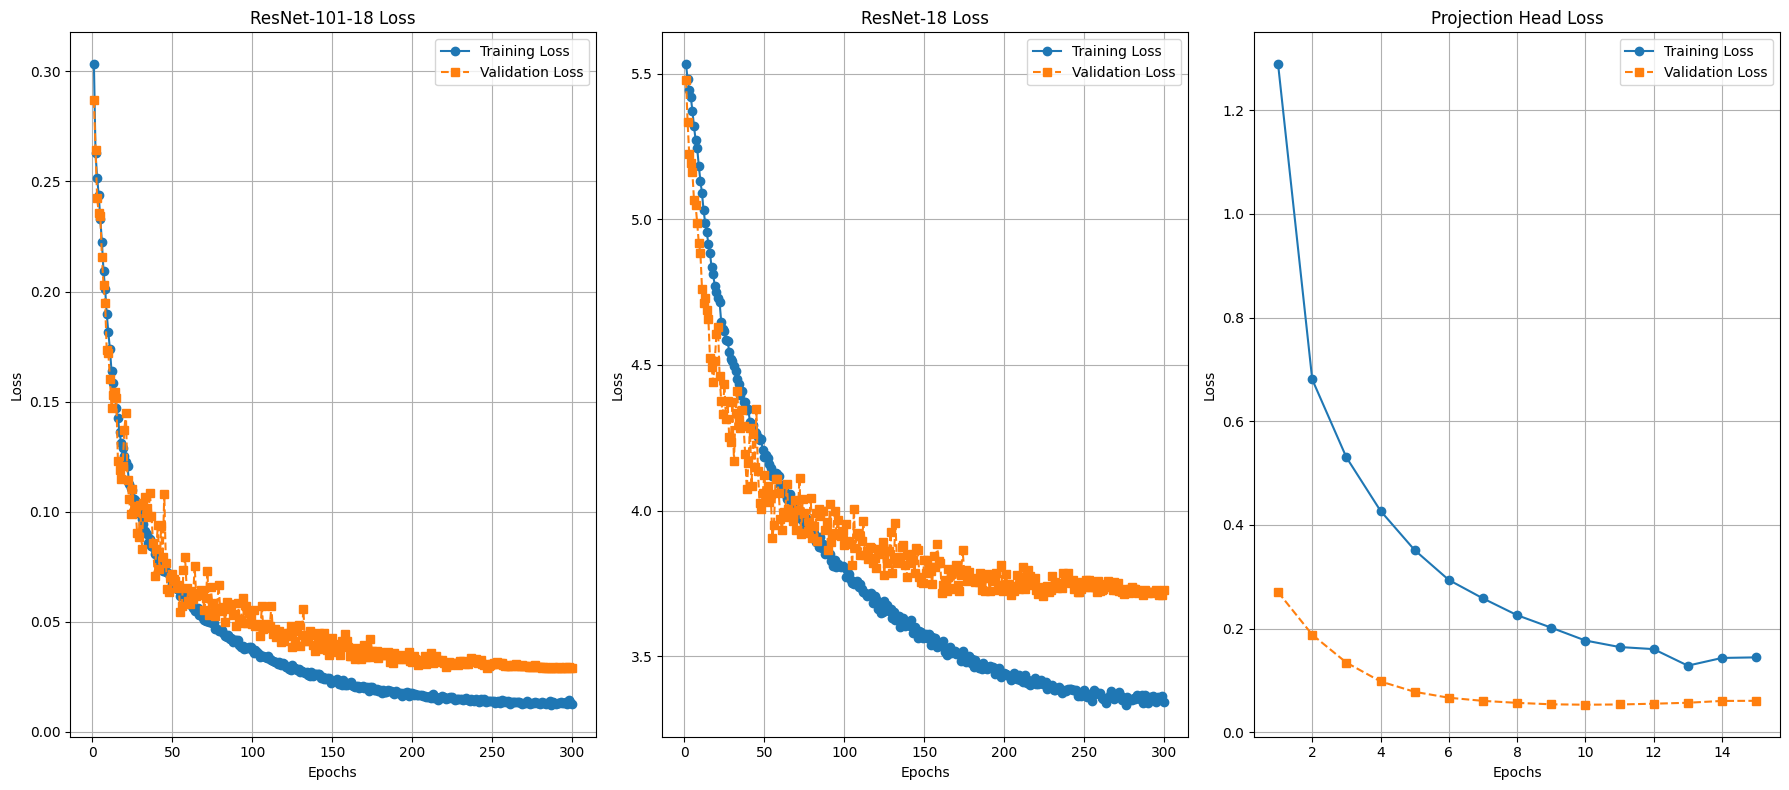

In [63]:
import pickle
import matplotlib.pyplot as plt

# Helper function to load data
def load_pickle(filepath):
    try:
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {filepath}")
    except Exception as e:
        raise RuntimeError(f"Error loading file {filepath}: {e}")

# Load data for all models
train_losses_resnet101 = load_pickle('/kaggle/working/Pickles/train_losses_encoder_resnet101_18.pkl')
valid_losses_resnet101 = load_pickle('/kaggle/working/Pickles/valid_losses_encoder_resnet101_18.pkl')

train_losses_resnet18 = load_pickle('/kaggle/working/Pickles/train_losses_encoder_resnet18.pkl')
valid_losses_resnet18 = load_pickle('/kaggle/working/Pickles/valid_losses_encoder_resnet18.pkl')

train_losses_projection_head = load_pickle('/kaggle/working/Pickles/train_losses_projection_head_student.pkl')
valid_losses_projection_head = load_pickle('/kaggle/working/Pickles/valid_losses_projection_head_student.pkl')

# Prepare data for plotting
def prepare_data(train_losses, valid_losses):
    if isinstance(train_losses, list) and isinstance(valid_losses, list):
        epochs = list(range(1, len(train_losses) + 1))
    elif isinstance(train_losses, dict) and isinstance(valid_losses, dict):
        common_epochs = sorted(set(train_losses.keys()) & set(valid_losses.keys()))
        if not common_epochs:
            raise ValueError("No common epochs found in train_losses and valid_losses.")
        train_losses = [train_losses[epoch] for epoch in common_epochs]
        valid_losses = [valid_losses[epoch] for epoch in common_epochs]
        epochs = common_epochs
    else:
        raise TypeError("train_losses and valid_losses must both be lists or both be dictionaries.")
    
    # Convert all loss values to float
    try:
        train_losses = [float(loss) for loss in train_losses]
        valid_losses = [float(loss) for loss in valid_losses]
    except ValueError as e:
        raise ValueError("Non-numeric loss values found.") from e
    
    return epochs, train_losses, valid_losses

# Prepare data for each model
epochs_resnet101, train_resnet101, valid_resnet101 = prepare_data(train_losses_resnet101, valid_losses_resnet101)
epochs_resnet18, train_resnet18, valid_resnet18 = prepare_data(train_losses_resnet18, valid_losses_resnet18)
epochs_proj_head, train_proj_head, valid_proj_head = prepare_data(train_losses_projection_head, valid_losses_projection_head)

# Plot the data
plt.figure(figsize=(18, 8))

# Plot for ResNet-101
plt.subplot(1, 3, 1)
plt.plot(epochs_resnet101, train_resnet101, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs_resnet101, valid_resnet101, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet-101-18 Loss')
plt.legend()
plt.grid(True)

# Plot for ResNet-18
plt.subplot(1, 3, 2)
plt.plot(epochs_resnet18, train_resnet18, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs_resnet18, valid_resnet18, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet-18 Loss')
plt.legend()
plt.grid(True)

# Plot for Projection Head
plt.subplot(1, 3, 3)
plt.plot(epochs_proj_head, train_proj_head, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs_proj_head, valid_proj_head, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Projection Head Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
